# Long Short Term Memory (LSTM) Model

Although RNNs are effective in remembering short sequences, they can't keep track of relations across longer sequences. This is due to the vanishing gradient problem. Repeated multiplications of values less than 1 results in vanishingly small gradients. LSTMs perform better than RNNs by incorporating both short term memory (as a hidden state) and longer term memory (as a cell state).

The core concepts of LSTMs is a gate. Gates allow or reject information to flow across sequences based on relevance to the task. LSTMs consist of forget, input, and output gates.

<img src="https://d2mk45aasx86xg.cloudfront.net/image17_11zon_2727417658.webp" alt="LSTM model" style="width: 700px;"/>

Let's go over the gates one by one:

## Forget Gate
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" alt="Forget Gate" style="width: 700px;"/>
The forget gate dictates whether information from the previous time step (hidden state) should be remembered or forgotten. It does this by concatenating the previous hidden state $h^{(t-1)}$ and the current input $x^{(t)}$ and passing it through a fully connected layer and a sigmoid function, resulting in a forget vector, $f^{(t)}$. For each element in $f^{(t)}$, if it is closer to 0, that element will be forgotten more easily and if it closer to 1, the corresponding element will be remembered longer. Finally, this forget vector is element wise multiplied with the previous cell state $C^{(t-1)}$. The data (cell state) is remembered/forgotten by multiplying each element with a weight that represents how strongly the element should be remembered (forget vector).

If we are just trying to determine whether to forget the previous memory, why do we need to use the current input $x^{(t)}$? The model needs to know what information is relevant when it is deciding what to remember. $x^{(t)}$ provides this context with which the model can evaluate past history.

## Input Gate
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png" alt="Input Gate" style="width: 700px;"/>
The input gate's job is to add new information to the cell memory for future computation. It does this in two steps. First, a similar computation to the forget gate is done (with different weights, of course) to create an input vector $i^{(t)}$.

Similar to the forget vector, this input vector selects parts of memory that should be updated. Next, the previous hidden state $h^{(t-1)}$ and the current input $x^{(t)}$ are concatenated and passed through another fully connected layer. However, this time, a tanh activation is used, resulting in a vector of new candidate values, $\tilde{C}^{(t)}$. This vector is the actual data to be added to the previous memory. Values are between -1 and 1 with negative values removing information and positive values adding information.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" alt="Cell State" style="width: 700px;"/>
Finally, the input vector $i^{(t)}$ and new candidate values $\tilde{C}^{(t)}$ are elementwise multiplied and added to the output of the forget gate. This results in the new cell state, $C^{(t)}$.

## Output Gate
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" alt="Output Gate" style="width: 700px;"/>
The output gate calculates the output for the current step. This output is the updated hidden state $h^{(t)}$. An output vector $o^{(t)}$ is calculated using a similar method as for the forget vector. This output vector is element wise multiplied by tanh of the current cell state, resulting in the new hidden state. As before, tanh of the cell state is the actual data returned scaled between -1 to 1. The output vector simply selects which elements to return. This hidden state is propagated to the next time step as well as returned as the output for the current step.

Let's implement a character level LSTM to classify names by language.

In [1]:
# Import necessary packages
import requests
import io
import zipfile
import os
import unicodedata
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import math
import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

# Loading Data
The RNN Pytorch tutorial (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) provides a dataset which you can download. However, in this notebook, just read the data into memory directly.

In [2]:
# Define all letters in ascii plus some additional characters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_names_dataset():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    url = 'https://download.pytorch.org/tutorial/data.zip'
    r = requests.get(url)
    with io.BytesIO(r.content) as zip_bytes:
        with zipfile.ZipFile(zip_bytes) as f:
            zip_contents = f.namelist()
            
            for filename in zip_contents:
                # Skip over irrelevant files and folders
                if 'data/names' not in filename or '.' not in filename:
                    continue
                category = os.path.splitext(os.path.basename(filename))[0]
                all_categories.append(category)
                lines = f.read(filename).decode('utf-8').strip().split('\n')
                lines = [unicodeToAscii(line) for line in lines]
                category_lines[category] = lines
    return all_categories, category_lines

In [3]:
all_categories, category_lines = read_names_dataset()
n_categories = len(all_categories)

In [4]:
print(all_categories)
print(category_lines['Italian'][:5])

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Now that the data is loaded in, define a few helper functions to convert between character and numerical representation. Also define a function to return the most likely language given probabilities output from the model.

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

Finally, define functions to randomly sample data from the dataset. This will be useful when querying data during training.

**Note:** The way the data is being sampled is important. The code below randomly samples a language and then randomly chooses a name from that language. This is different from just randomly sampling a name from the set of all names. Randomly sampling a name from the set of all names would result in training heavily on over represented languages while not learning enough from languages with fewer names in the dataset.

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Defining the Model

Now we define the LSTM model. As explained above, the six steps are:

$$
f^{(t)} = \sigma{( W_f[h^{(t-1)}, x^{(t)}] + b_f )}
$$

$$
i^{(t)} = \sigma{( W_i[h^{(t-1)}, x^{(t)}] + b_i )}
$$

$$
\tilde{C}^{(t)} = tanh( W_C[h^{(t-1)}, x^{(t)}] + b_C )
$$

$$
C^{(t)} = f^{(t)} \odot C^{(t-1)} + i^{(t)} \odot \tilde{C}^{(t)}
$$

$$
o^{(t)} = \sigma{( W_o[h^{(t-1)}, x^{(t)}] + b_o )}
$$

$$
h^{(t)} = o^{(t)} \odot tanh( C^{(t)} )
$$

Let's write a model implementing these steps.

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.new_cell_update = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        # Adding another layer to convert from n_hidden to n_output, where n_output is number of predicted categories
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, cell_state):
        combined = torch.cat((x, hidden), 1)
        
        forget_vector = self.sigmoid(self.forget_gate(combined))
        input_vector = self.sigmoid(self.input_gate(combined))
        output_vector = self.sigmoid(self.output_gate(combined))
        
        new_candidate_values = self.tanh(self.new_cell_update(combined))
        new_cell_state = forget_vector * cell_state + input_vector * new_candidate_values
        
        hidden = output_vector * self.tanh(new_cell_state)
        output = self.softmax(self.output_layer(hidden))
        return output, hidden, new_cell_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, self.hidden_size)

In [10]:
n_hidden = 128
model = LSTM(n_letters, n_hidden, n_categories)
print(model)

LSTM(
  (forget_gate): Linear(in_features=185, out_features=128, bias=True)
  (input_gate): Linear(in_features=185, out_features=128, bias=True)
  (output_gate): Linear(in_features=185, out_features=128, bias=True)
  (new_cell_update): Linear(in_features=185, out_features=128, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (output_layer): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# Training

To train the model, define a criterion function to calculate the loss. NLLLoss is used here.

A train function is also defined where it takes a single name and iterates over each of the characters in the name, passing the character as input to the model as well as the previous hidden state. After all characters are passed to the model, the loss is calculated using the final output and target category and the gradients are calculated with loss.backward(). Then the gradients are manually added to the weights. **Note:** this could have also been simplified by using an optimizer to update weights automatically.

In [13]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = model.initHidden()
    cell = model.initCell()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = model(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Finally, run the training process for n_iters iterations. Keep track of losses for plotting.

In [14]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.9335 Soler / French ✗ (Spanish)
10000 10% (0m 27s) 2.8421 Luu / Chinese ✗ (Vietnamese)
15000 15% (0m 41s) 2.8284 Aiello / Spanish ✗ (Italian)
20000 20% (0m 55s) 2.8792 Mcintosh / Greek ✗ (Scottish)
25000 25% (1m 9s) 1.9960 Panayiotopoulos / Greek ✓
30000 30% (1m 22s) 2.7148 Kido / Chinese ✗ (Japanese)
35000 35% (1m 36s) 1.6490 Kan / Chinese ✓
40000 40% (1m 50s) 3.0202 Serafin / Irish ✗ (Polish)
45000 45% (2m 3s) 1.8624 Sabbagh / Arabic ✓
50000 50% (2m 17s) 1.1046 Banh / Vietnamese ✓
55000 55% (2m 31s) 1.8432 Toma / Vietnamese ✗ (Arabic)
60000 60% (2m 45s) 1.2552 Garcia / Portuguese ✓
65000 65% (2m 59s) 2.2870 Smith / Arabic ✗ (Scottish)
70000 70% (3m 12s) 0.6258 Hairov / Russian ✓
75000 75% (3m 26s) 4.2777 Fergus / Portuguese ✗ (Irish)
80000 80% (3m 40s) 0.8540 Wehner / German ✓
85000 85% (3m 54s) 1.4147 Melo / Spanish ✗ (Portuguese)
90000 90% (4m 8s) 3.0032 Tomas / Arabic ✗ (Spanish)
95000 95% (4m 21s) 1.3798 Chu / Vietnamese ✗ (Chinese)
100000 100% (4m 35s) 0.7323 

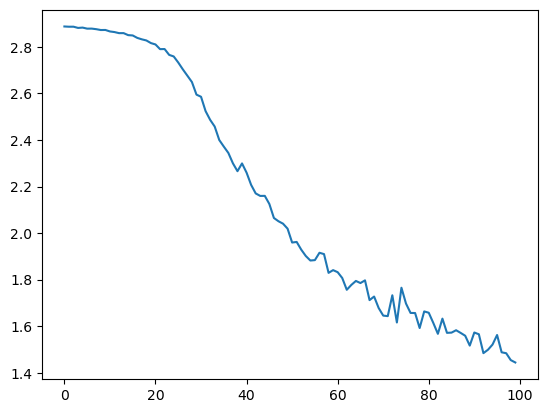

In [15]:
plt.figure()
plt.plot(all_losses)

# Evaluation

The model can be evaluated by creating a confusion matrix. The training set wasn't split into a validation set for simplicity. Randomly sample n_confusion samples from the training set and plot the guesses in the confusion matrix.

C:\Users\shrey\AppData\Local\Temp\ipykernel_27576\938437755.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\shrey\AppData\Local\Temp\ipykernel_27576\938437755.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


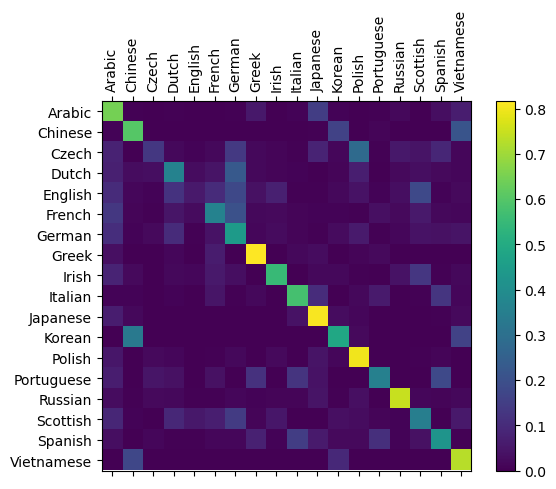

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()
    cell = model.initCell()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = model(line_tensor[i], hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Most of the names are classified correctly as seen from the bright diagonal. There are a few dimmer squares off the diagonal representing misclassified names.

A predict function is optionally defined below to easily test out other names that are not in the original dataset.

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.98) Russian
(-1.43) Polish
(-1.84) Czech

> Jackson
(-0.96) Scottish
(-1.89) English
(-2.01) Polish

> Satoshi
(-0.25) Japanese
(-2.29) Arabic
(-2.79) Polish


# Resources
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/